# Multimodal on Azure AI Search using Azure AI Vision

This code demonstrates a no-indexer approach to vectorization of image content and queries on Azure AI Search.

It uses [Azure AI Vision 4.0](https://learn.microsoft.com/en-us/azure/ai-services/computer-vision/how-to/image-retrieval) for multimodal embeddings. You must have a [Computer Vision resource](https://ms.portal.azure.com/#create/Microsoft.CognitiveServicesComputerVision) to get your key and endpoint. Be sure to create the resource in one of the permitted geographic regions: East US, France Central, Korea Central, North Europe, Southeast Asia, West Europe, West US. You can use the free tier to run this demo.

In constrast with the [multimodal-custom-skill example](https://github.com/Azure/azure-search-vector-samples/tree/main/demo-python/code/multimodal-custom-skill) that uses indexers and skills for Azure AI Vision image vectorization, this example uses the [push approach](https://learn.microsoft.com/azure/search/search-what-is-data-import) to indexing.

+ Create an embeddings instance
+ Load and vectorize image files from a local folder
+ Create an index
+ Push vectorized image content to the index
+ Run image queries

This is a pure image search scenario, with no text input from users. For an example of the multimodal embeddings over text search, see the [multimodal-custom-skill example](https://github.com/Azure/azure-search-vector-samples/tree/main/demo-python/code/multimodal-custom-skill).

### Set up a Python virtual environment in Visual Studio Code

1. Open the Command Palette (Ctrl+Shift+P).
1. Search for **Python: Create Environment**.
1. Select **Venv**.
1. Select a Python interpreter. Choose 3.10 or later.

It can take a minute to set up. If you run into problems, see [Python environments in VS Code](https://code.visualstudio.com/docs/python/environments).

### Install packages

In [2]:
! pip install -r azure-search-vector-image-python-sample-requirements.txt --quiet

### Load .env file

Copy `.env-sample` to an `.env` file in the sample folder, and update accordingly. The search service and Azure AI Vision endpoint must exist, but the search index is created and loaded during code execution. Provide a unique name for the index and make sure your search service has sufficient quota. Endpoints and API keys can be found in the Azure portal.

In [30]:
from dotenv import load_dotenv
from azure.identity import DefaultAzureCredential
from azure.core.credentials import AzureKeyCredential
import os

load_dotenv(override=True) # take environment variables from .env.

# Variables not used here do not need to be updated in your .env file
endpoint = os.environ["AZURE_SEARCH_SERVICE_ENDPOINT"]
credential = AzureKeyCredential(os.environ["AZURE_SEARCH_ADMIN_KEY"]) if len(os.environ["AZURE_SEARCH_ADMIN_KEY"]) > 0 else DefaultAzureCredential()
index_name = os.environ["AZURE_SEARCH_INDEX"]
vision_key = os.environ["AZURE_AI_VISION_KEY"]
vision_endpoint = os.environ["AZURE_AI_VISION_ENDPOINT"]

### Create image embedding

Sets up an embedding instance.

In [31]:
import requests
import os
from tenacity import (
    Retrying,
    retry_if_exception_type,
    wait_random_exponential,
    stop_after_attempt
)
import json
import mimetypes

params = {  
        "api-version": "2023-02-01-preview",
        "overload": "stream",
        "modelVersion": "latest"
}
url = f"{vision_endpoint}/computervision/retrieval:vectorizeImage"  

def vectorize_image(image_path):
    mime_type, _ = mimetypes.guess_type(image_path)
    headers = {  
        "Content-Type": mime_type,
        "Ocp-Apim-Subscription-Key": vision_key  
    }
    for attempt in Retrying(
        retry=retry_if_exception_type(requests.HTTPError),
        wait=wait_random_exponential(min=15, max=60),
        stop=stop_after_attempt(15)
    ):
        with attempt:
            with open(image_path, 'rb') as image_data:
                response = requests.post(url, params=params, headers=headers, data=image_data)  
                if response.status_code != 200:  
                    response.raise_for_status()
    vector = response.json()["vector"]
    return vector

### Embed images

Vectorize all the images and save them into a [json lines](https://jsonlines.org/) file at `\data\images\apples\output.jsonl`.

In [32]:
real_estate_image_directory = os.path.join('data')
input_json_file = os.path.join(real_estate_image_directory, 'input.json')
output_json_file = os.path.join(real_estate_image_directory, 'output.jsonl')
with open(input_json_file, 'r') as infile:
    images = json.load(infile)

with open(output_json_file, 'w') as outfile:
    for idx, image_data in enumerate(images):
        image_path = image_data.get('image_path', None)
        if image_path:
            try:
                vector = vectorize_image(os.path.join(real_estate_image_directory, image_path))
            except Exception as e:
                print(f"Error processing image at index {idx}: {e}")
                vector = None
            
            filename, _ = os.path.splitext(os.path.basename(image_path))
            result = {
                "id": f'{idx}',
                "image_vector": vector,
                "description": filename
            }

            outfile.write(json.dumps(result))
            outfile.write('\n')
            outfile.flush()

print(f"Results are saved to {output_json_file}")

Results are saved to data\output.jsonl


### Create an index

Create a search index schema and vector search configuration on Azure AI Search.

In [33]:
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes.models import (
    SimpleField,
    SearchField,
    SearchFieldDataType,
    VectorSearch,
    HnswAlgorithmConfiguration,
    VectorSearchProfile,
    SearchIndex
)

# Create a search index 
index_client = SearchIndexClient(endpoint=endpoint, credential=credential)  
fields = [  
    SimpleField(name="id", type=SearchFieldDataType.String, key=True),  
    SearchField(name="description", type=SearchFieldDataType.String, sortable=True, filterable=True, facetable=True),  
    SearchField(
        name="image_vector",  
        hidden=True,
        type=SearchFieldDataType.Collection(SearchFieldDataType.Single), 
        searchable=True,
        vector_search_dimensions=1024,  
        vector_search_profile_name="myHnswProfile"
    ),  
]  
  
# Configure the vector search configuration  
vector_search = VectorSearch(  
    algorithms=[  
        HnswAlgorithmConfiguration(  
            name="myHnsw"
        )
    ],  
   profiles=[  
        VectorSearchProfile(  
            name="myHnswProfile",  
            algorithm_configuration_name="myHnsw",  
        )
    ],  
)  
  
# Create the search index with the vector search configuration  
index = SearchIndex(name=index_name, fields=fields, vector_search=vector_search)  
result = index_client.create_or_update_index(index)  
print(f"{result.name} created") 

my-demo-index created


### Push local data to the index

In [34]:
from azure.search.documents import SearchClient
import json

image_directory = os.path.join('data')
output_json_file = os.path.join(image_directory, 'output.jsonl')

data = []
with open(output_json_file, 'r') as file:
    for line in file:
        # Remove leading/trailing whitespace and parse JSON
        json_data = json.loads(line.strip())
        data.append(json_data)

search_client = SearchClient(endpoint=endpoint, index_name=index_name, credential=credential)
results = search_client.upload_documents(data)
for result in results:
    print(f'Indexed {result.key} with status code {result.status_code}')

Indexed 0 with status code 200
Indexed 1 with status code 200
Indexed 2 with status code 200
Indexed 3 with status code 200
Indexed 4 with status code 200
Indexed 5 with status code 200
Indexed 6 with status code 200


### Perform an image vector search

Perform a vector search to find the most relevant images based on an image query.

Search results for data\house-10.png:


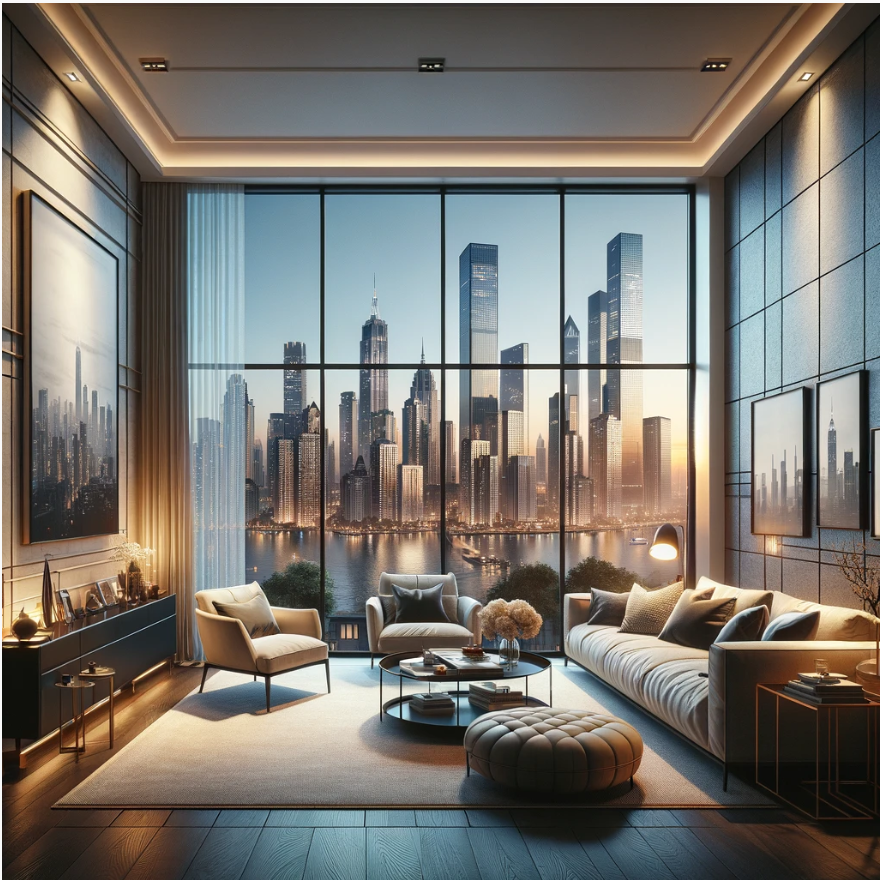

House Type: house-5


House Type: house-3




In [35]:
from azure.search.documents.models import VectorizedQuery
from IPython.display import Image

# Generate text embeddings for the query  
query_image_path = os.path.join(image_directory, "house-10.png")
vector_query = VectorizedQuery(vector=vectorize_image(query_image_path),
                              k_nearest_neighbors=2, 
                              fields="image_vector")  

# Perform vector search  
results = search_client.search(  
    search_text=None,  
    vector_queries= [vector_query],
    select=["description"],
    top=2
)   
  
# Print the search results 
print(f"Search results for {query_image_path}:") 
display(Image(query_image_path))
for result in results:
    print(f"House Type: {result['description']}")
    print("\n") 